In [1]:
!pip install lime
!pip install shap
import shap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import seaborn as sns

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_data(annotation_file, physiological_file):
    # Read annotation data
    annotation_data = pd.read_csv(annotation_file)

    # Classify emotion based on valence and arousal
    def classify_emotion(arousal, valence):
        arousal_bins = [-26225, -13112, 0, 13112, 26225]
        valence_bins = [-26225, -13112, 0, 13112, 26225]

        arousal_label = pd.cut([arousal], bins=arousal_bins,
                               labels=False, include_lowest=True)
        valence_label = pd.cut([valence], bins=valence_bins,
                               labels=False, include_lowest=True)

        return f'Partition_{arousal_label}_{valence_label}'
    
    annotation_data = annotation_data[annotation_data['video'].isin([3.0, 4.0])]

    annotation_data['Emotion_Partition'] = annotation_data.apply(
        lambda row: classify_emotion(row['arousal'], row['valence']), axis=1)

    # Define the rectangular partition
    rectangular_partition = {
        'arousal': (-3000, 3000), 'valence': (-3000, 3000)}
    
    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data['Emotion'] = ''

    for index, row in annotation_data.iterrows():
        arousal = row['arousal']
        valence = row['valence']

        if -3000 <= arousal <= 3000 and -3000 <= valence <= 3000:
            annotation_data.loc[index, 'Emotion'] = 'Neutral'
        else:
            if -26225 <= arousal <= -13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Anxious or Dejected'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tired or Bored'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index, 'Emotion'] = 'Polite or Sleepy'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Relaxed or Calm'
            elif -13112 <= arousal <= 0:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index, 'Emotion'] = 'Miserable or Sad'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Worried or Apathetic'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Confident or Attentive'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Pleased or Glad'
            elif 0 <= arousal <= 13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Discontented'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Impatient'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Passionate or Amused'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Delighted or Happy'
            else:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Distressed or Defiant'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tensed or Annoyed'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Aroused or Astonished'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Excited or Adventurous'
                    
    # Scatter plot with color-coded partitions
    c = annotation_data['Emotion_Partition'].astype('category').cat.codes
    plt.scatter(annotation_data['valence'], annotation_data['arousal'],
                c=c, cmap='viridis', label='Other Partitions')

    # Draw vertical lines for Arousal partitions
    arousal_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in arousal_bins[1:-1]:
        plt.axvline(x=bin_value, color='black', linestyle='--', linewidth=1)

    # Draw horizontal lines for Valence partitions
    valence_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in valence_bins[1:-1]:
        plt.axhline(y=bin_value, color='black', linestyle='--', linewidth=1)

    # Create a mask for points inside the rectangular partition
    mask = (
        (annotation_data['arousal'] >= rectangular_partition['arousal'][0]) &
        (annotation_data['arousal'] <= rectangular_partition['arousal'][1]) &
        (annotation_data['valence'] >= rectangular_partition['valence'][0]) &
        (annotation_data['valence'] <= rectangular_partition['valence'][1])
    )

    # Scatter plot for points inside the rectangular partition with a different color
    plt.scatter(annotation_data.loc[mask,
                'valence'], annotation_data.loc[mask, 'arousal'], c='red', label='Rectangular Partition')

    plt.title(
        'Emotion Partitions based on Arousal and Valence with Extra Partition Rectangle')
    plt.xlabel('Arousal')
    plt.ylabel('Valence')
    plt.legend()
    plt.show()

    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data_1 = annotation_data.drop('Emotion_Partition', axis=1)
    physiological_data = pd.read_csv(physiological_file)
    # Assuming you have a DataFrame named 'merged_data' with columns 'video_x', 'video_y', and 'time'

    annotation_data_1['jstime'] = annotation_data_1['jstime'].astype('int')
    physiological_data['daqtime'] = physiological_data['daqtime'].astype('int')

    annotation_data_1.rename(columns={"jstime": "time"}, inplace=True)

    physiological_data.rename(columns={"daqtime": "time"}, inplace=True)

    merged_data = pd.merge(
        annotation_data_1, physiological_data, on="time", how="left")

    return merged_data

# merged_data = preprocess_data(f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_annotation/sub_{subject}.csv',
#                               f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_physiological/sub_{subject}.csv')
    

In [3]:
# print(X_test[0:100])
# np.array(shap_values_RF_test).shape

Creating legend with loc="best" can be slow with large amounts of data.


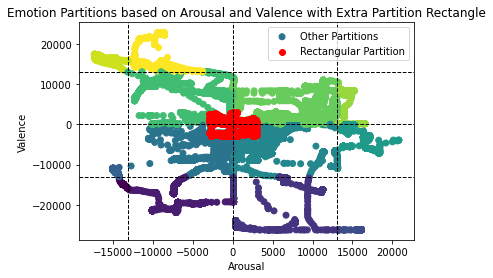

['Confident or Attentive' 'Passionate or Amused' 'Delighted or Happy'
 'Polite or Sleepy' 'Tired or Bored' 'Anxious or Dejected'
 'Miserable or Sad' 'Worried or Apathetic' 'Frustrated or Impatient'
 'Tensed or Annoyed' 'Relaxed or Calm' 'Pleased or Glad'
 'Distressed or Defiant' 'Frustrated or Discontented']
        valence  arousal  video_x                 Emotion      ecg        bvp  \
1464     3061.0   -841.0      3.0  Confident or Attentive  0.78690  37.097290   
1466     3061.0   -841.0      3.0  Confident or Attentive  0.65220  36.826065   
1467     3061.0   -841.0      3.0  Confident or Attentive  0.78362  35.111686   
1468     3441.0   -865.0      3.0  Confident or Attentive  0.78362  36.235206   
1470     3441.0   -865.0      3.0  Confident or Attentive  0.61606  36.583908   
...         ...      ...      ...                     ...      ...        ...   
275438   5746.0    940.0      3.0    Passionate or Amused  1.33558  36.186799   
275439   5746.0    936.0      3.0    Passi

In [4]:
#FOR 20-24 AGE CATEGORY all merged

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# Preprocess data for the current subject
merged_data_1 = preprocess_data(
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/boring_25-29_annotations.csv',
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/boring_25-29_physiological.csv'
)
    

merged_data_1['valence'] = merged_data_1['valence'].fillna(method="ffill")
merged_data_1['arousal'] = merged_data_1['arousal'].fillna(method="ffill")
merged_data_1 = merged_data_1[merged_data_1['video_x'] == merged_data_1['video_y']]
merged_data_1 = merged_data_1[merged_data_1['Emotion'] != 'Neutral']
sub_data = merged_data_1.drop('time', axis=1)
print(sub_data['Emotion'].unique())
print(sub_data)
print(len(sub_data))
label_encoder = LabelEncoder()
X=sub_data.drop(['Emotion','valence','arousal','video_y','video_x'],axis=1)
y=sub_data['Emotion']
y_encoded = label_encoder.fit_transform(sub_data['Emotion'])
encoded_classes = label_encoder.classes_
y = y_encoded

print(len(X))
print(len(y))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)





TIME to interpret

 11393.120156049728 seconds


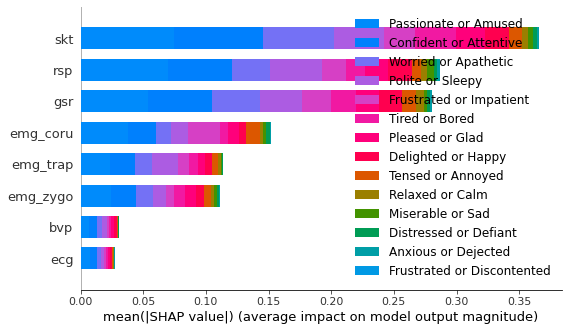

In [5]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
t0 = time.time()
explainerRF = shap.TreeExplainer(rf)
shap_values_RF_test = explainerRF.shap_values(X_test[0:100])
t1 = time.time()
timeit=t1-t0
print("TIME to interpret\n\n",timeit, "seconds")
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()

class_names = encoded_classes
shap.summary_plot(shap_values_RF_test, X_test,class_names=class_names)


In [6]:
y_test

array([1, 7, 7, ..., 8, 7, 7])

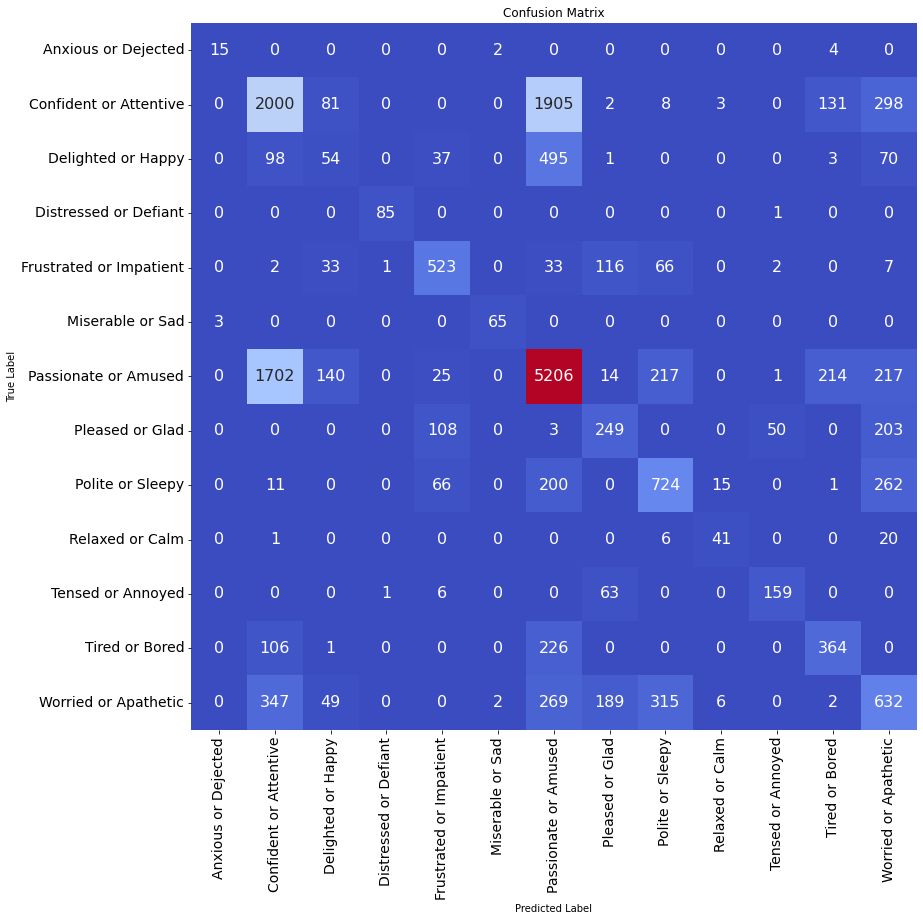

<Figure size 432x288 with 0 Axes>

In [7]:

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Extract unique labels from y_test
unique_labels = sorted(set(y_test))

# Create a filtered list of class names
filtered_class_names = [class_names[i] for i in unique_labels]

plt.figure(figsize=(13, 13))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names,
            annot_kws={"size": 16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
plt.savefig("amusing_confusion_matrix.png", bbox_inches='tight', dpi=300)


0.5445981590138343


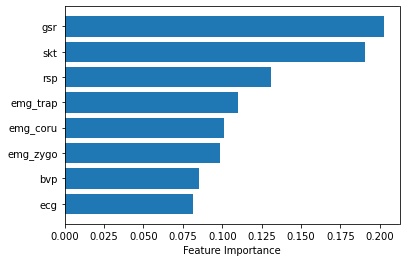

In [8]:
print(accuracy_score(y_test,y_pred))
feature_importances = rf.feature_importances_

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plotting the feature importances
plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

In [9]:
instance_index = 99
print(X_test.iloc[instance_index])
print(class_names[y_test[instance_index]])
for i in range(len(class_names)):
    print(class_names[i])
    print(shap_values_RF_test[i][instance_index][:])

ecg          0.806620
bvp         38.724523
gsr         15.435408
rsp         42.468081
skt         29.491084
emg_zygo     4.700750
emg_coru     5.440000
emg_trap     7.370250
Name: 126796, dtype: float64
Tired or Bored
Anxious or Dejected
[-3.38695140e-04  7.59803236e-05  2.71424433e-03 -6.49421421e-03
  2.09892787e-03  2.77541333e-03 -2.41143887e-03  4.45269217e-04]
Confident or Attentive
[-0.02275059 -0.01918007 -0.0387841   0.02613191  0.03080921  0.02843718
  0.00920054  0.00519465]
Delighted or Happy
[-7.68475980e-03 -1.60945247e-03  2.17900459e-02  8.88654688e-03
 -8.87141926e-06 -2.31706434e-02  9.64466215e-03  1.41308714e-03]
Distressed or Defiant
[-1.77774540e-04  1.68248594e-05  5.75679862e-04 -9.77611167e-04
 -1.31760632e-03 -9.02212468e-04 -8.72951536e-04 -1.46919177e-04]
Frustrated or Discontented
[-3.41454072e-06  2.95428597e-06  2.85972910e-06 -5.83942878e-06
 -5.17484780e-06 -3.31798791e-06 -5.82386619e-07 -2.15409179e-06]
Frustrated or Impatient
[ 0.00030282 -0.000569

In [10]:
colour_scheme = 'cool'

FOR  Anxious or Dejected


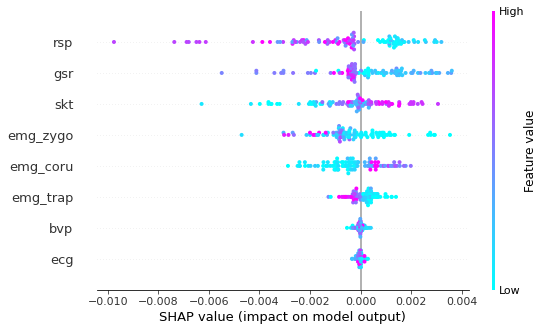

<Figure size 432x288 with 0 Axes>

FOR  Confident or Attentive


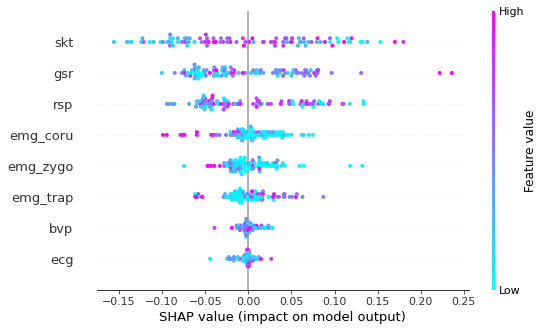

<Figure size 432x288 with 0 Axes>

FOR  Delighted or Happy


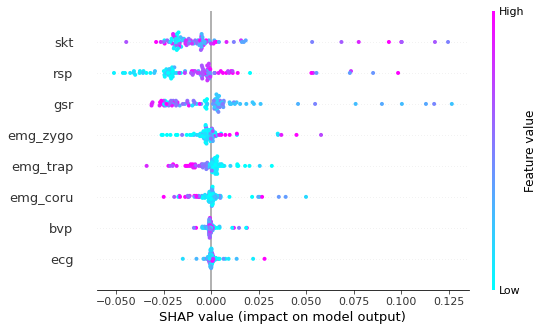

<Figure size 432x288 with 0 Axes>

FOR  Distressed or Defiant


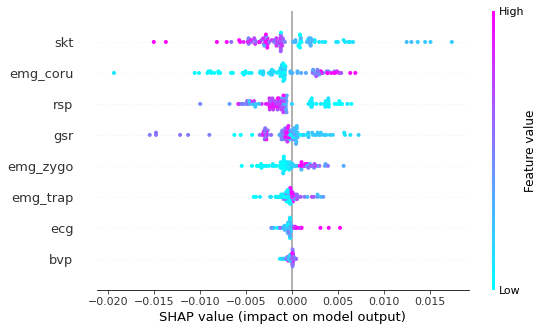

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Discontented


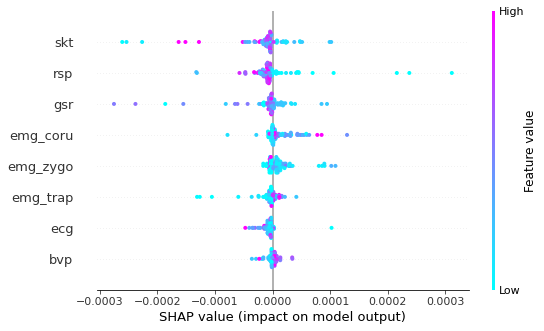

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Impatient


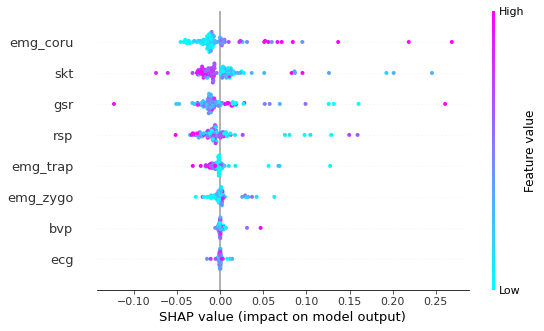

<Figure size 432x288 with 0 Axes>

FOR  Miserable or Sad


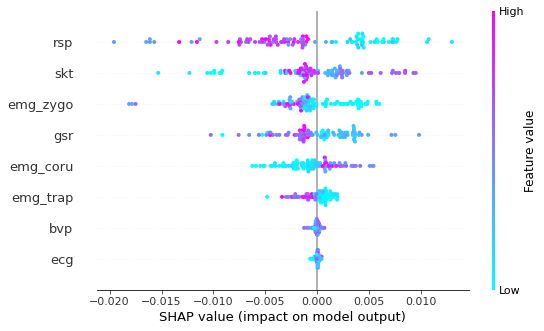

<Figure size 432x288 with 0 Axes>

FOR  Passionate or Amused


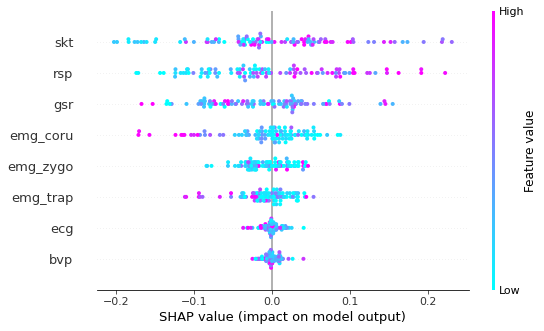

<Figure size 432x288 with 0 Axes>

FOR  Pleased or Glad


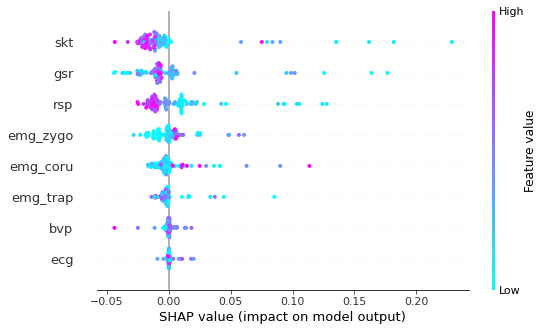

<Figure size 432x288 with 0 Axes>

FOR  Polite or Sleepy


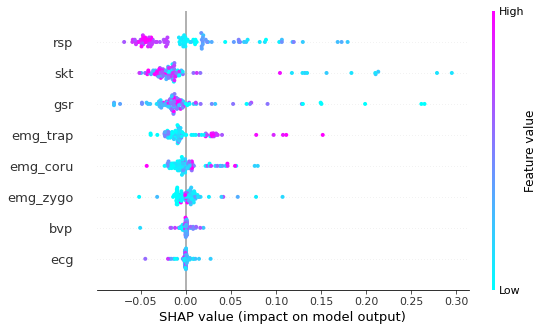

<Figure size 432x288 with 0 Axes>

FOR  Relaxed or Calm


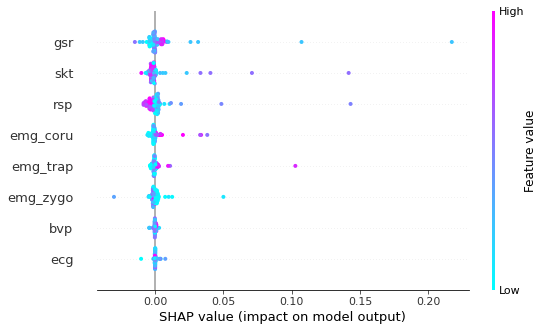

<Figure size 432x288 with 0 Axes>

FOR  Tensed or Annoyed


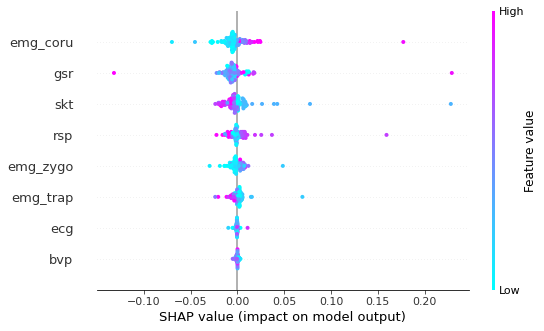

<Figure size 432x288 with 0 Axes>

FOR  Tired or Bored


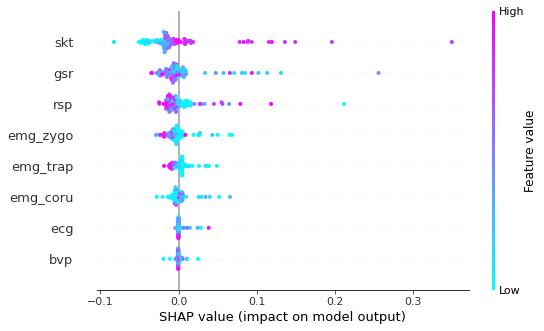

<Figure size 432x288 with 0 Axes>

FOR  Worried or Apathetic


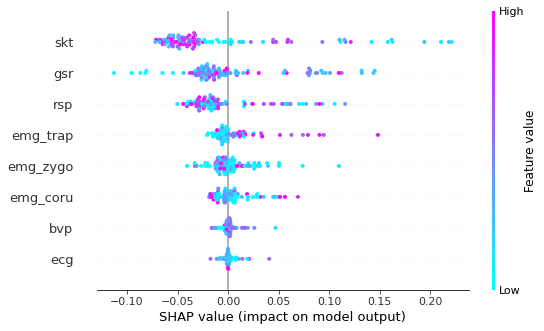

<Figure size 432x288 with 0 Axes>

In [11]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,cmap=colour_scheme)
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png', bbox_inches='tight')
    plt.show()

FOR  Anxious or Dejected


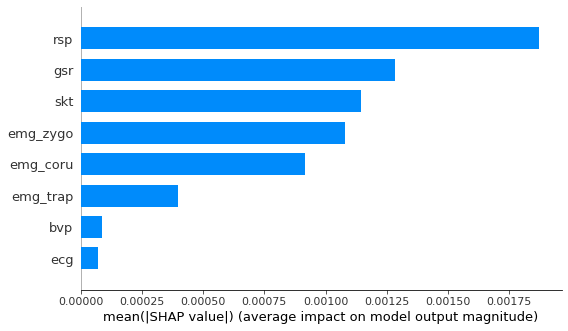

FOR  Confident or Attentive


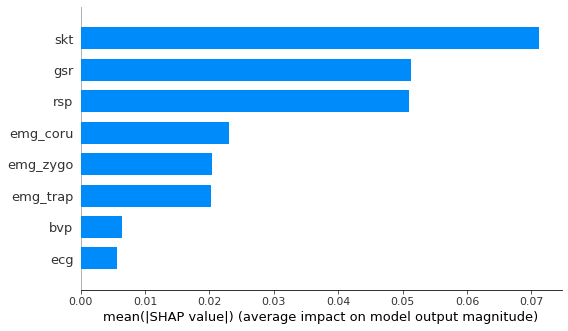

FOR  Delighted or Happy


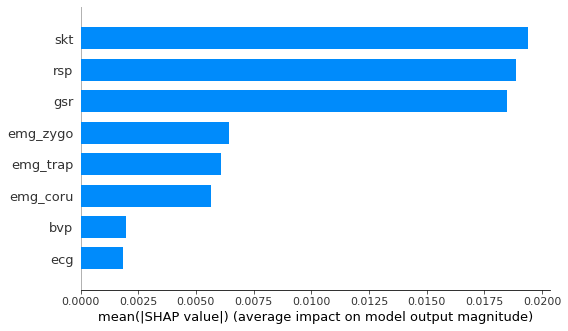

FOR  Distressed or Defiant


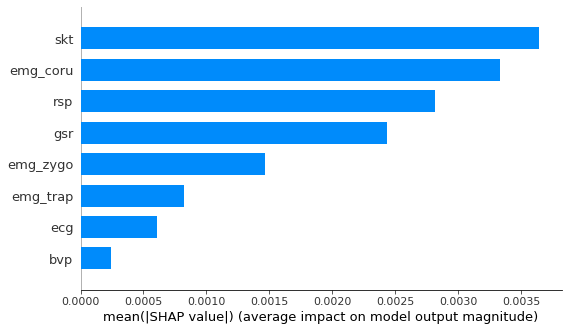

FOR  Frustrated or Discontented


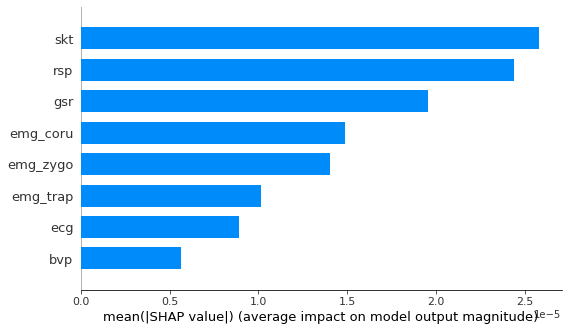

FOR  Frustrated or Impatient


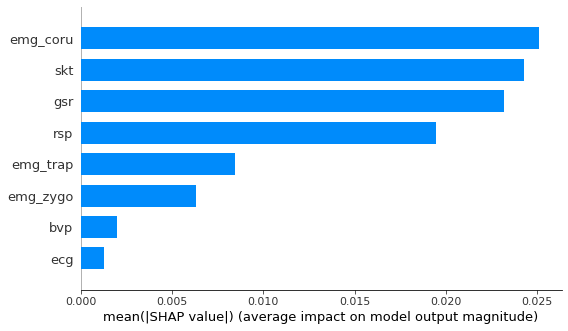

FOR  Miserable or Sad


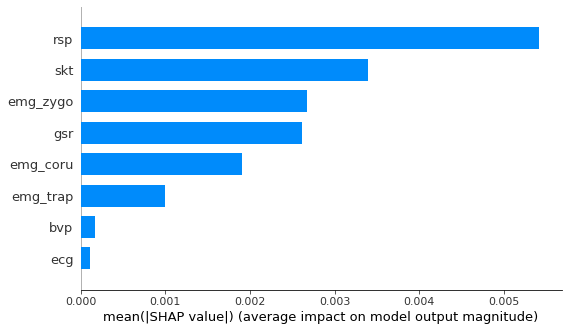

FOR  Passionate or Amused


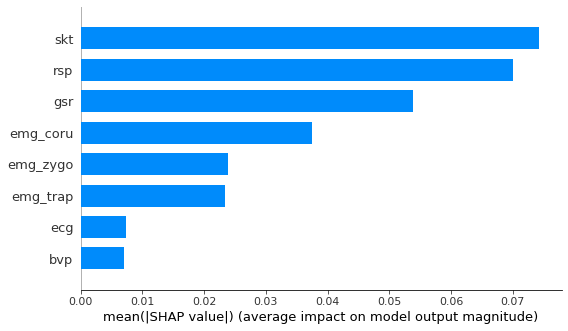

FOR  Pleased or Glad


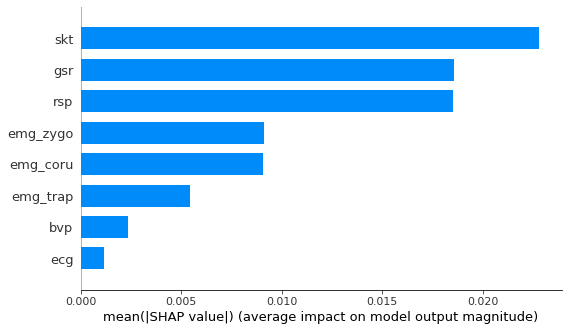

FOR  Polite or Sleepy


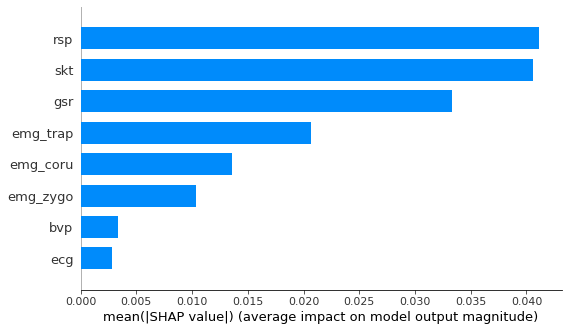

FOR  Relaxed or Calm


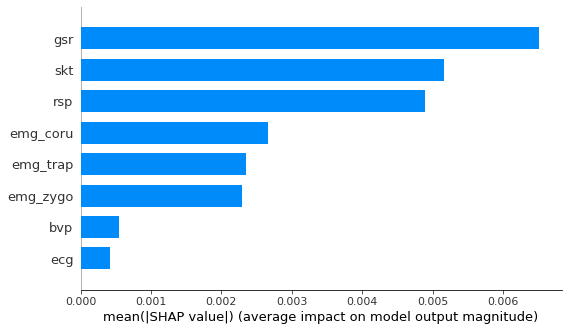

FOR  Tensed or Annoyed


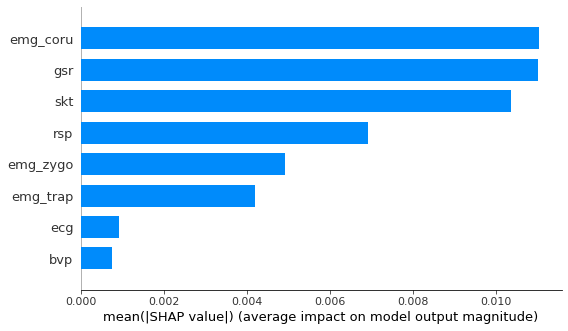

FOR  Tired or Bored


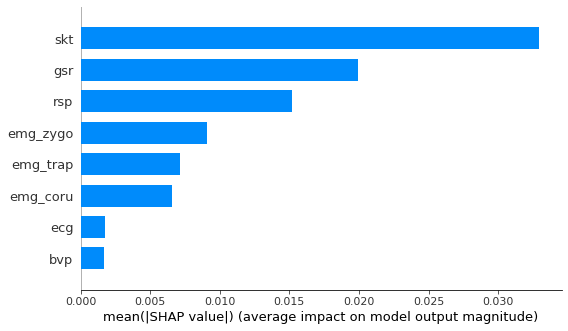

FOR  Worried or Apathetic


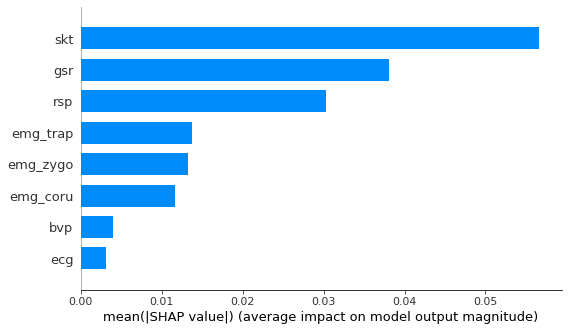

<Figure size 432x288 with 0 Axes>

In [12]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,plot_type="bar")

plt.tight_layout()

# Save or show the plot
plt.savefig('shap_summary_plot.png', bbox_inches='tight')
plt.show()

In [13]:
shap.initjs()
from IPython.display import display
print(X_test.iloc[instance_index])
print(class_names[y_test[instance_index]])

for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index][:], X_test.iloc[[instance_index]], plot_cmap="GnPR"))
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][:][:], X_test.iloc[0:100],plot_cmap="GnPR"))

ecg          0.806620
bvp         38.724523
gsr         15.435408
rsp         42.468081
skt         29.491084
emg_zygo     4.700750
emg_coru     5.440000
emg_trap     7.370250
Name: 126796, dtype: float64
Tired or Bored
CLASS  Anxious or Dejected


CLASS  Anxious or Dejected


CLASS  Confident or Attentive


CLASS  Confident or Attentive


CLASS  Delighted or Happy


CLASS  Delighted or Happy


CLASS  Distressed or Defiant


CLASS  Distressed or Defiant


CLASS  Frustrated or Discontented


CLASS  Frustrated or Discontented


CLASS  Frustrated or Impatient


CLASS  Frustrated or Impatient


CLASS  Miserable or Sad


CLASS  Miserable or Sad


CLASS  Passionate or Amused


CLASS  Passionate or Amused


CLASS  Pleased or Glad


CLASS  Pleased or Glad


CLASS  Polite or Sleepy


CLASS  Polite or Sleepy


CLASS  Relaxed or Calm


CLASS  Relaxed or Calm


CLASS  Tensed or Annoyed


CLASS  Tensed or Annoyed


CLASS  Tired or Bored


CLASS  Tired or Bored


CLASS  Worried or Apathetic


CLASS  Worried or Apathetic


In [14]:
import time
start = time.time()
explanation = explainerRF(X_test[0:100])
end = time.time()
print(end-start)

166.51187920570374


In [15]:
# shap.plots.force(explanation[0])
np.array(explanation).shape
print(X_test)
feature_names = ['ecg','bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap']

            ecg        bvp        gsr        rsp        skt  emg_zygo  \
45727   0.80332  35.160093  23.407272  33.524277  30.795211   5.27575   
84914   1.12860  36.709851  35.242920  46.223715  29.445499   6.46675   
63862   0.66862  37.136028  17.990184  37.066904  28.232519   4.78300   
6882    0.71134  38.986020  15.896688  37.415375  28.463899   4.86500   
189310  0.89532  35.305376  34.430736  45.884908  28.295603   8.93075   
...         ...        ...        ...        ...        ...       ...   
110103  1.04316  34.792053  16.373736  37.802558  28.404293   4.90625   
122695  0.69162  36.312742  27.077808  42.255133  28.972220  14.31075   
251771  0.76390  35.644407  20.655360  27.300358  32.050275   5.85075   
150827  0.81976  38.182073  31.998168  45.536437  28.796946   7.57550   
65384   0.68834  34.995413  18.794472  43.658620  29.929300  11.60025   

        emg_coru  emg_trap  
45727    6.13825  10.77900  
84914    6.71325   6.05600  
63862    5.60425   5.76850  
6882   

CLASS NAME  Anxious or Dejected


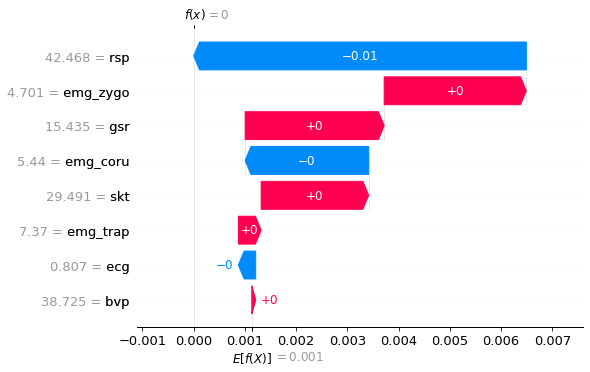

CLASS NAME  Confident or Attentive


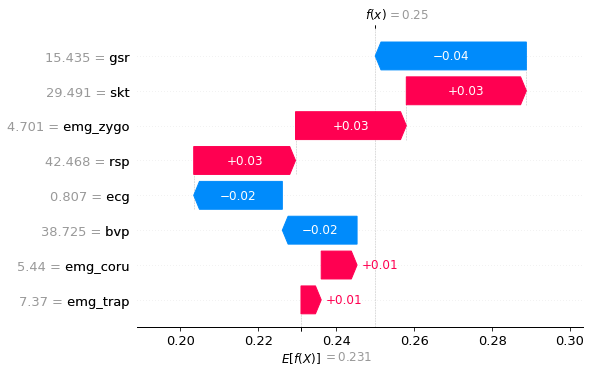

CLASS NAME  Delighted or Happy


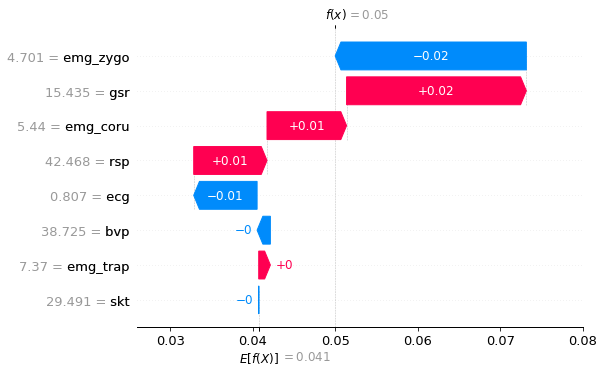

CLASS NAME  Distressed or Defiant


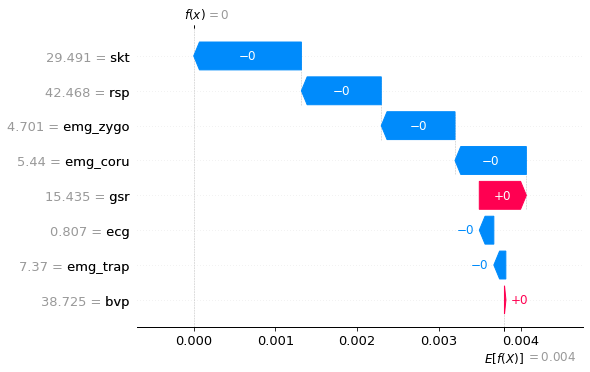

CLASS NAME  Frustrated or Discontented


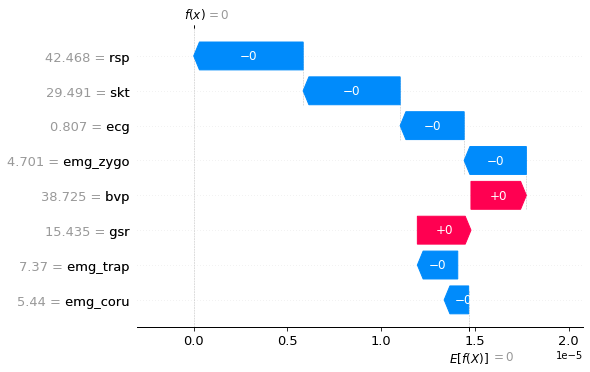

CLASS NAME  Frustrated or Impatient


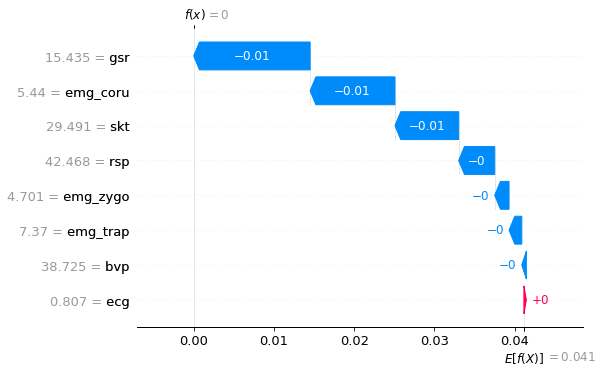

CLASS NAME  Miserable or Sad


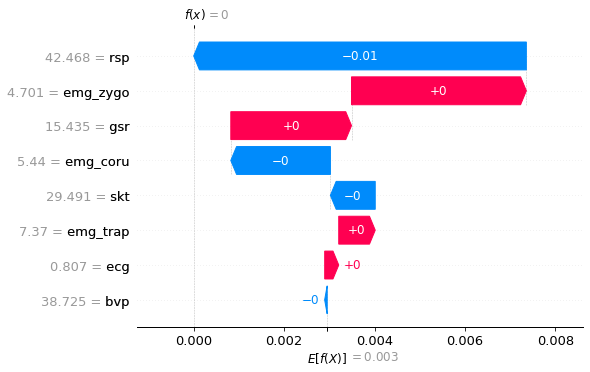

CLASS NAME  Passionate or Amused


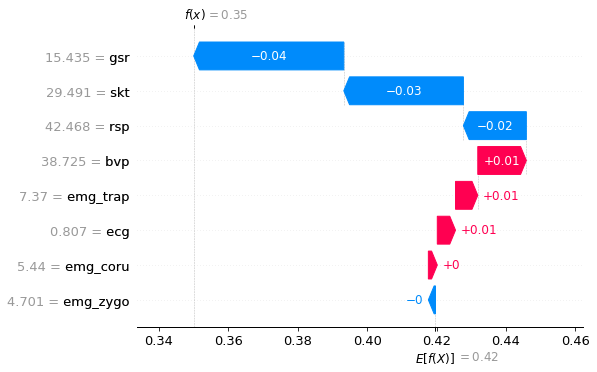

CLASS NAME  Pleased or Glad


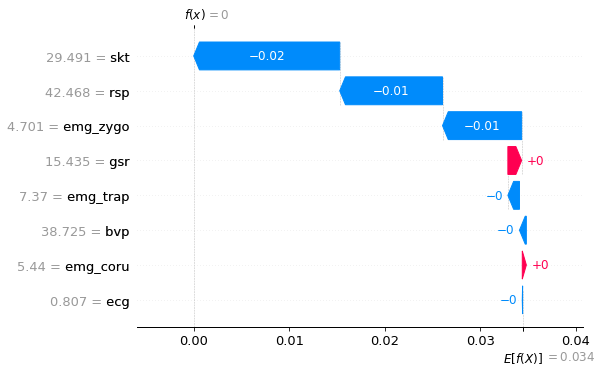

CLASS NAME  Polite or Sleepy


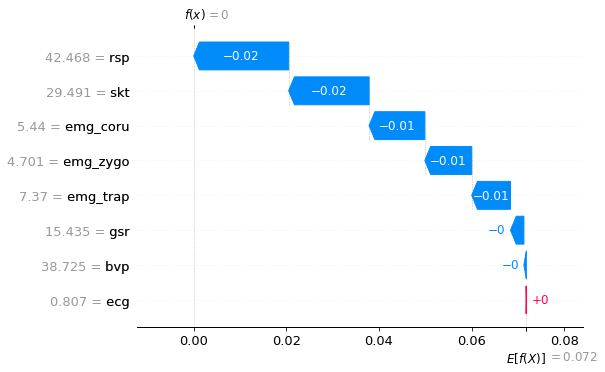

CLASS NAME  Relaxed or Calm


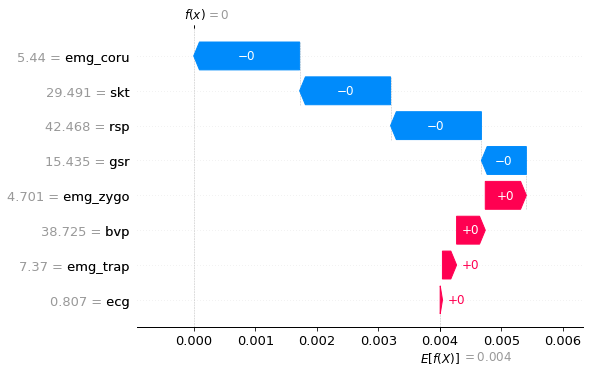

CLASS NAME  Tensed or Annoyed


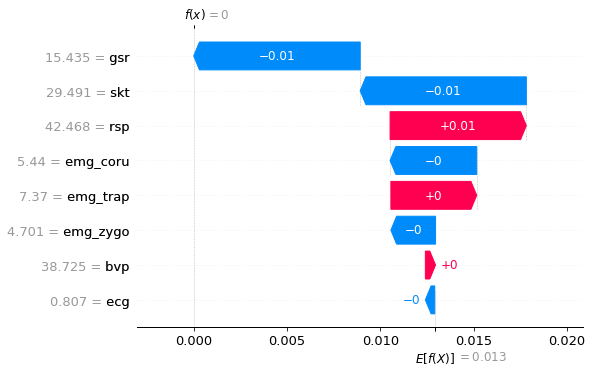

CLASS NAME  Tired or Bored


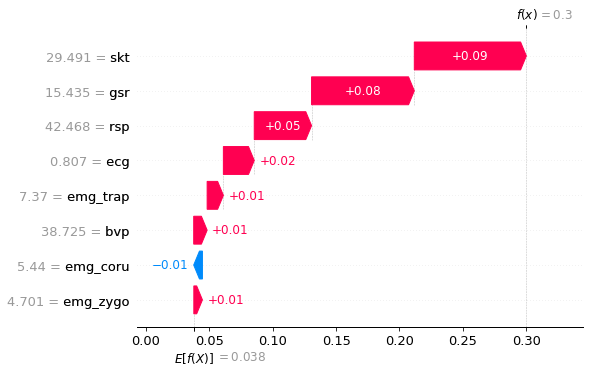

CLASS NAME  Worried or Apathetic


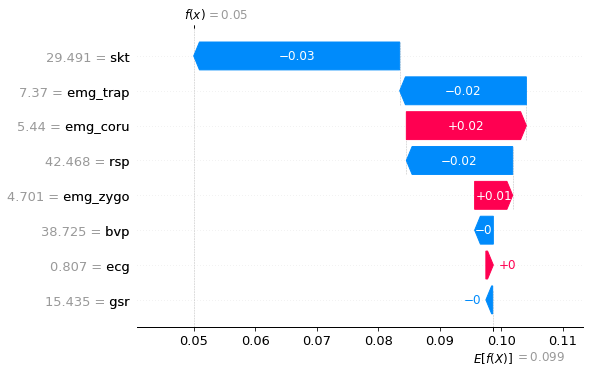

In [16]:
for i in range(len(class_names)):
    class_name = i
    print("CLASS NAME ", class_names[class_name])
    EXP = shap.Explanation(
        values=explanation[instance_index].values[:,class_name],
        base_values=explanation[instance_index].base_values[class_name],
        data = explanation[instance_index].data,
        feature_names = feature_names
    )
    shap.waterfall_plot(EXP,max_display = 8)

In [17]:
class_names[y_test[instance_index]]

'Tired or Bored'

In [18]:
X_test.iloc[instance_index]

ecg          0.806620
bvp         38.724523
gsr         15.435408
rsp         42.468081
skt         29.491084
emg_zygo     4.700750
emg_coru     5.440000
emg_trap     7.370250
Name: 126796, dtype: float64

CLASS  Anxious or Dejected


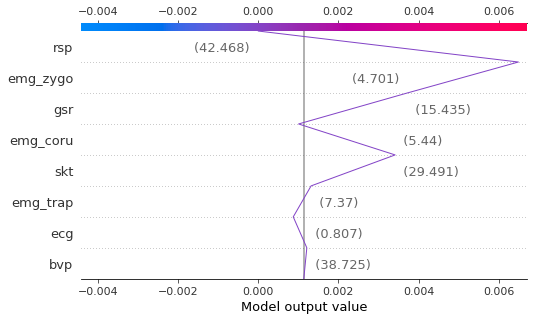

CLASS  Confident or Attentive


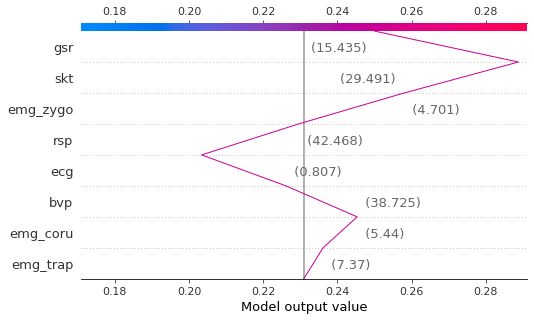

CLASS  Delighted or Happy


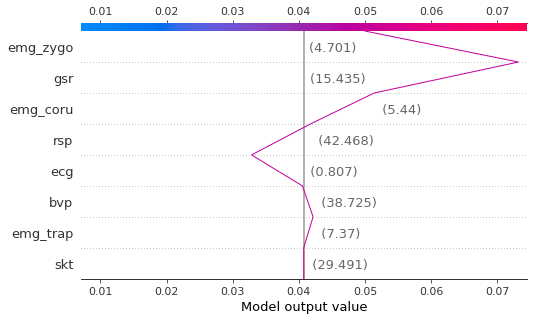

CLASS  Distressed or Defiant


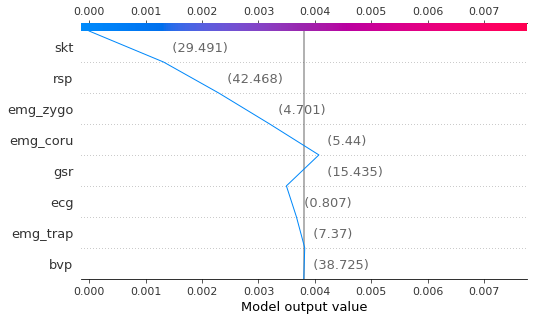

CLASS  Frustrated or Discontented


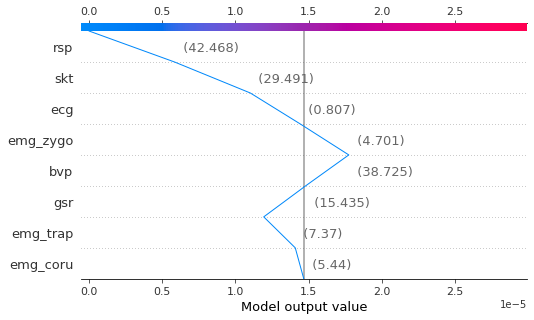

CLASS  Frustrated or Impatient


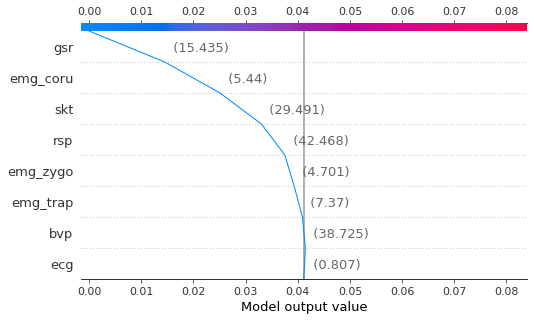

CLASS  Miserable or Sad


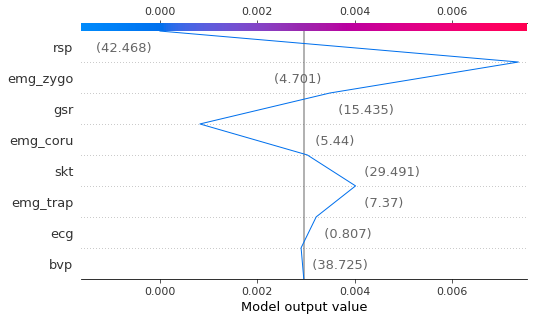

CLASS  Passionate or Amused


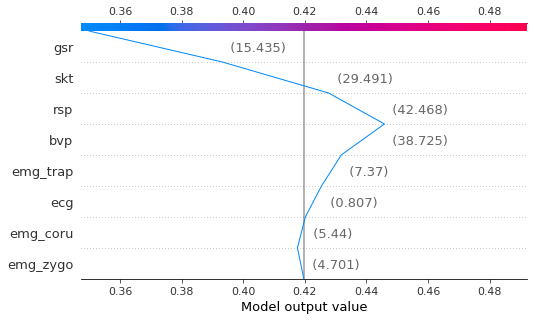

CLASS  Pleased or Glad


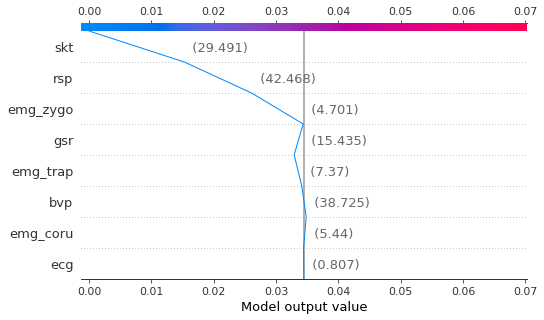

CLASS  Polite or Sleepy


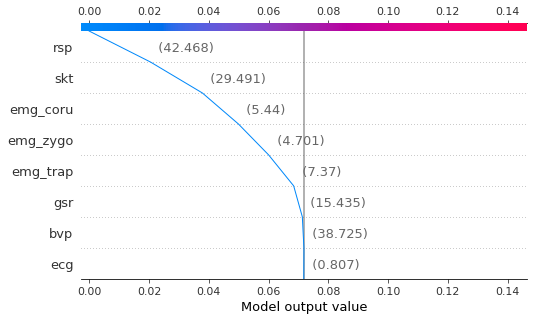

CLASS  Relaxed or Calm


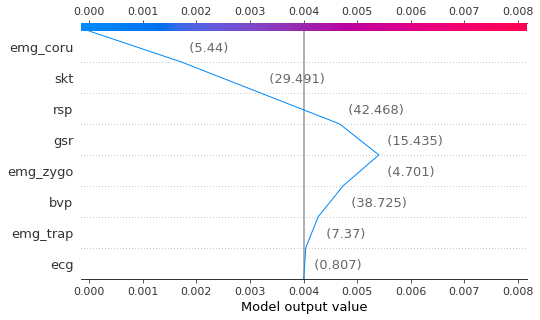

CLASS  Tensed or Annoyed


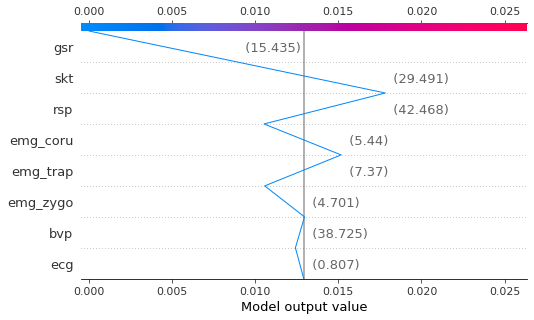

CLASS  Tired or Bored


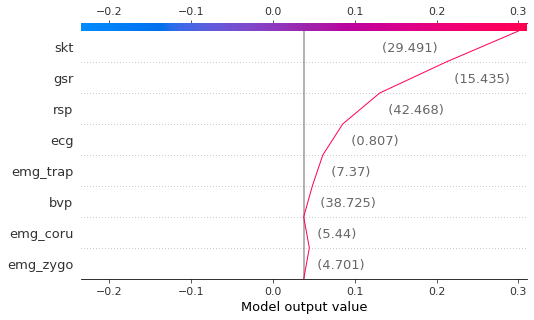

CLASS  Worried or Apathetic


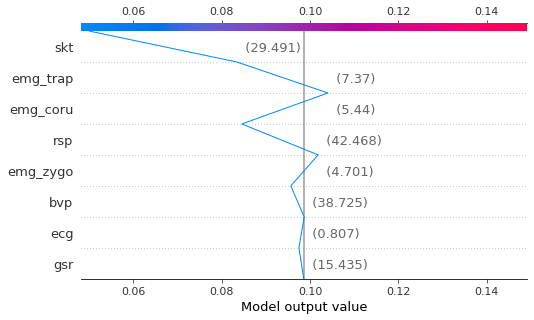

In [19]:
for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    shap.decision_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index], X_test.iloc[instance_index])

In [20]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, feature_names=X_train.columns, mode="classification",kernel_width=0.5)
t0 = time.time()

explanations_test = []

explanation_lime = explainer.explain_instance(
    X_test.values[instance_index], rf.predict_proba, num_features=10, top_labels=14)
explanations_test.append(explanation_lime)

t1 = time.time()
timeit = t1 - t0
print("TIME to interpret\n\n", timeit, "seconds")

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


TIME to interpret

 8.94179892539978 seconds


In [21]:
explanation = explanations_test[0]
explanation.show_in_notebook()

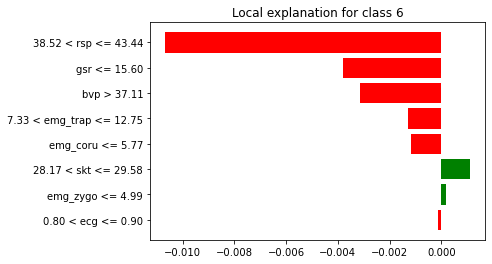

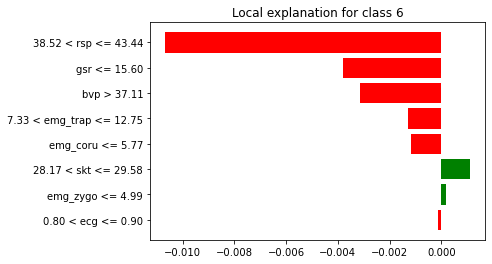

In [22]:
explanation.as_pyplot_figure(label=6)

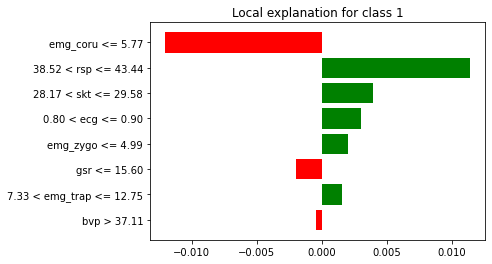

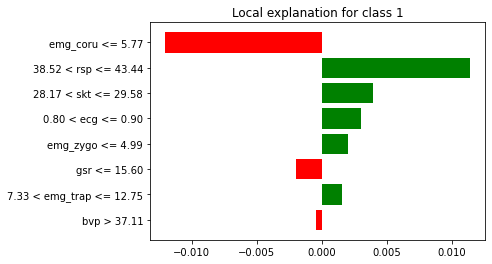

In [23]:
explanation.as_pyplot_figure(label=1)

TypeError: 'Explanation' object is not subscriptable